## 과제 3: 배우/감독 네트워크 분석 및 성공 패턴 발견
주요 배우와 감독들의 협업 관계를 네트워크로 시각화하고, 성공적인 콜라보레이션 패턴을 발견하여 캐스팅 전략에 대한 인사이트를 도출하세요.

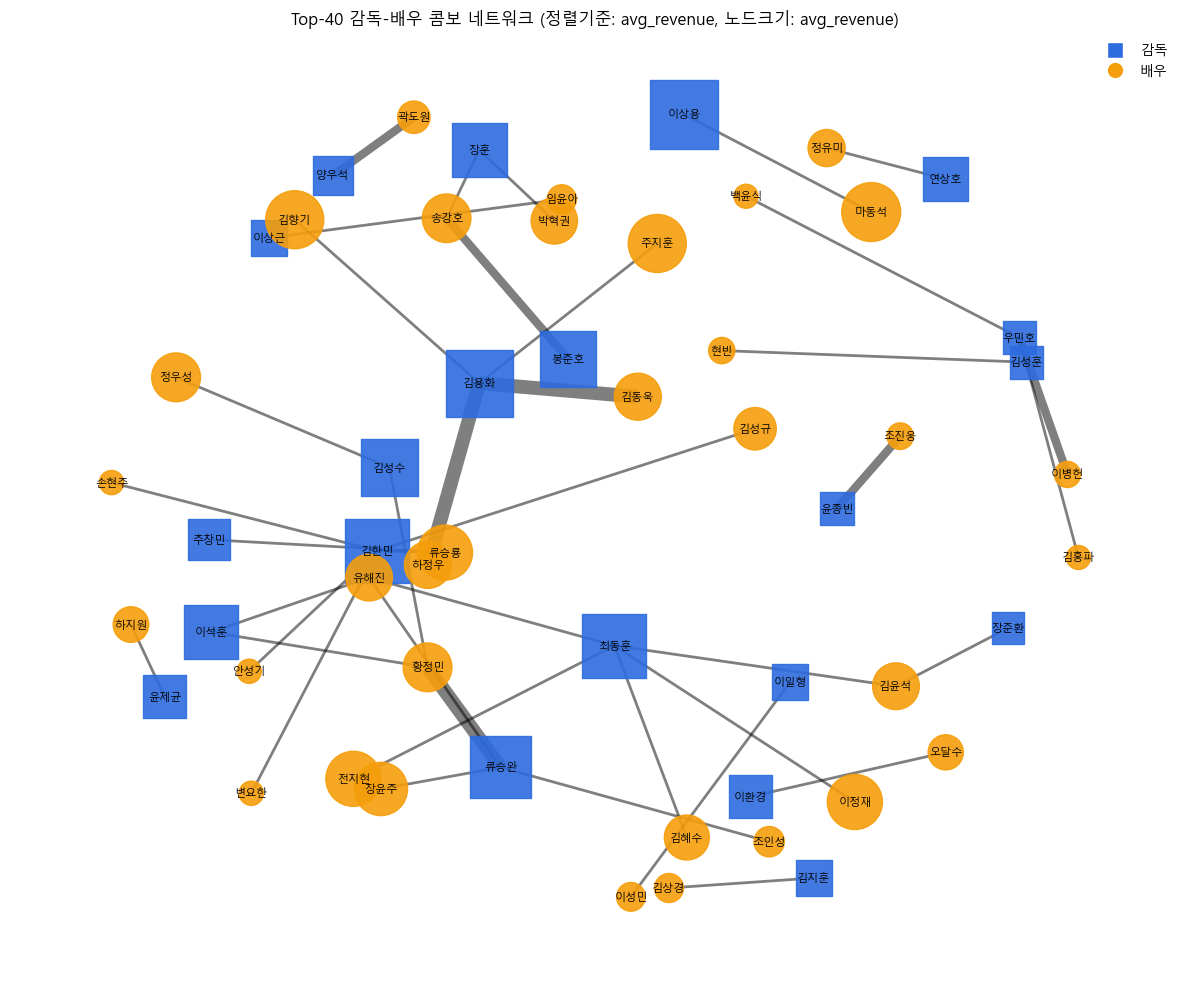

In [13]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itertools import islice
from IPython.display import display
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

# 한글 폰트 설정 (OS에 맞게)
import platform, matplotlib as mpl
if platform.system() == "Windows":
    FONT_KO = "Malgun Gothic"
elif platform.system() == "Darwin":
    FONT_KO = "AppleGothic"
else:
    FONT_KO = "NanumGothic"
mpl.rcParams["font.family"] = FONT_KO
mpl.rcParams["axes.unicode_minus"] = False

# =========================
# 0) 데이터 로드 및 전처리
# =========================
PATH = "data_processed/kobis_with_credits_ko.csv"
df = pd.read_csv(PATH)

# 숫자형 보정
num_cols = ["release_year","budget","revenue","vote_average","runtime"]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# 기간 필터 (선택)
if "release_year" in df.columns:
    df = df[df["release_year"].between(2005, 2025)]

# ROI/순이익
df["roi"] = np.where((df["budget"]>0) & (df["revenue"]>0),
                     df["revenue"]/df["budget"], np.nan)
df["net_profit"] = df["revenue"] - df["budget"]

# 파이프(|) 구분자로 저장된 감독/배우 열 파서
def split_pipe(s):
    return [x for x in str(s).split("|") if x]

# =========================
# 1) 감독-배우 엣지 생성 → 콤보 성과 집계
#   - 노드 키: 한글 이름으로 고유 키 사용
# =========================
TOP_N_CAST = 5
MIN_COLLABS = 2
METRIC_EDGE_ORDER = "avg_revenue"
TOP_K_EDGES = 40

rows = []
for _, r in df.iterrows():
    # 'director_name_ko'를 고유 키로 사용
    d_lab = str(r.get("director_name_ko") or "").strip()
    if not d_lab:
        continue

    # 'cast_names_ko'를 고유 키로 사용
    cast_labs = split_pipe(r.get("cast_names_ko"))
    
    # 배우 상위 N명
    for a_lab in list(cast_labs[:TOP_N_CAST]):
        rows.append({
            "director_label": d_lab,
            "actor_label": a_lab,
            "movie_id": r.get("movie_id"),
            "release_year": r.get("release_year"),
            "revenue": r.get("revenue"),
            "budget": r.get("budget"),
            "roi": r.get("roi"),
            "net_profit": r.get("net_profit"),
        })

edges = (pd.DataFrame(rows)
         .groupby(["director_label", "actor_label"], as_index=False)
         .agg(n_collabs=("movie_id","nunique"),
              avg_revenue=("revenue","mean"),
              avg_roi=("roi","mean"),
              avg_net_profit=("net_profit","mean"),
              first_year=("release_year","min"),
              last_year=("release_year","max"))
         .query("n_collabs >= @MIN_COLLABS")
         .sort_values([METRIC_EDGE_ORDER,"n_collabs"], ascending=[False, False])
        )

sub = edges.head(TOP_K_EDGES).copy()

# =========================
# 2) 그래프 구성 (한글 이름을 노드키와 라벨로 사용)
# =========================
G = nx.Graph()
for _, r in sub.iterrows():
    u = ("director", r["director_label"])
    v = ("actor", r["actor_label"])
    G.add_node(u, role="director", label=r["director_label"])
    G.add_node(v, role="actor", label=r["actor_label"])
    G.add_edge(u, v,
        weight=int(r["n_collabs"]),
        avg_revenue=float(r["avg_revenue"]) if pd.notna(r["avg_revenue"]) else 0.0,
        avg_net_profit=float(r["avg_net_profit"]) if pd.notna(r["avg_net_profit"]) else 0.0,
        avg_roi=float(r["avg_roi"]) if pd.notna(r["avg_roi"]) else 0.0
    )

# =========================
# 3) 시각화 설정
# =========================
pos = nx.spring_layout(G, seed=42, k=0.8)

directors = [n for n, d in G.nodes(data=True) if d["role"] == "director"]
actors = [n for n, d in G.nodes(data=True) if d["role"] == "actor"]

w = [G.edges[e]["weight"] for e in G.edges()]
w_min, w_max = min(w), max(w)
edge_widths = [6]*len(w) if w_max==w_min else [2 + 8*((val-w_min)/(w_max-w_min)) for val in w]

METRIC_NODE_SIZE = "avg_revenue"

for _, r in sub.iterrows():
    for nkey, label in [(("director", r["director_label"]), r["director_label"]),
                        (("actor", r["actor_label"]), r["actor_label"])]:
        prev = G.nodes[nkey].get(METRIC_NODE_SIZE, 0.0)
        cur = float(r[METRIC_NODE_SIZE]) if pd.notna(r[METRIC_NODE_SIZE]) else 0.0
        if cur > prev:
            G.nodes[nkey][METRIC_NODE_SIZE] = cur

metric_map = {n: G.nodes[n].get(METRIC_NODE_SIZE, 0.0) for n in G.nodes()}
vals = np.array(list(metric_map.values()), dtype=float)
vals_log = np.log1p(np.abs(vals))
vmin, vmax = float(vals_log.min()), float(vals_log.max())
norm = {n: (np.log1p(abs(metric_map[n])) - vmin) / (vmax - vmin) if vmax > vmin else 0.5 for n in G.nodes()}

MIN_SIZE_ACT, MAX_SIZE_ACT = 300, 1800
MIN_SIZE_DIR, MAX_SIZE_DIR = 500, 2400
size_map = {n: (MIN_SIZE_DIR + x*(MAX_SIZE_DIR-MIN_SIZE_DIR)) if G.nodes[n]["role"]=="director"
            else (MIN_SIZE_ACT + x*(MAX_SIZE_ACT-MIN_SIZE_ACT))
            for n, x in norm.items()}

# =========================
# 4) 그리기
# =========================
plt.figure(figsize=(12,10))

# 엣지
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.5)

# 감독: 파란 사각형
nx.draw_networkx_nodes(
    G, pos, nodelist=directors,
    node_size=[size_map[n] for n in directors],
    node_color="#2D6CDF", node_shape="s", alpha=0.9
)

# 배우: 주황 원형
nx.draw_networkx_nodes(
    G, pos, nodelist=actors,
    node_size=[size_map[n] for n in actors],
    node_color="#F59E0B", node_shape="o", alpha=0.9
)

# 라벨(한글 original_name)
labels = {n: d.get("label") for n, d in G.nodes(data=True)}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, font_family=FONT_KO)

plt.title(f"Top-{TOP_K_EDGES} 감독-배우 콤보 네트워크 "
          f"(정렬기준: {METRIC_EDGE_ORDER}, 노드크기: {METRIC_NODE_SIZE})")
plt.axis("off")

from matplotlib.lines import Line2D
legend_elems = [
    Line2D([0],[0], marker='s', color='w', label='감독',
           markerfacecolor='#2D6CDF', markersize=12),
    Line2D([0],[0], marker='o', color='w', label='배우',
           markerfacecolor='#F59E0B', markersize=12)
]
plt.legend(handles=legend_elems, loc="best", frameon=False)
plt.tight_layout()
plt.show()